In [299]:
# store start time to get execution time of entire script
import time
start_time = time.time()

In [300]:
# helper functions for displaying table data

import numpy as np
from IPython.display import display_html

# n is the number of columns to display data in
def display_side_by_side(series_obj, n):
    df = pd.DataFrame(series_obj)
    partition = int(round(len(df) / n))
    lower_bound = 0
    upper_bound = partition
    args = []
    for i in range(n):
        args.append(df[lower_bound:upper_bound])
        lower_bound += partition
        upper_bound += partition
    helper(args)

def helper(args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [301]:
# helper function for plotting out ground truth curves

import matplotlib.pyplot as plt

def get_ground_truth(data):
    relapsed = data[data.Illicit_Cens0 == 0]
    counts = relapsed['Illicit_Days0'].value_counts()
    counts = counts.to_dict()
    temp = [len(data)] * 365
    labels = list(range(365))
    for i in range(365):
        labels[i] += 1
    total = 0
    errors = []
    for i in range(365):
        try:
            temp[i] = temp[i] - counts[i+1] - total
            total = total + counts[i+1]
        except KeyError:
            errors.append(i)

    for ele in sorted(errors, reverse = False):
        if ele != 0:
            temp[ele] = temp[ele-1]
        else:
             temp[0] = len(data)
    temp = [x / len(data) for x in temp]
    return labels, temp

In [302]:
# helper function to formulate filename to save graphs

def set_filename(base):
    global INCLUDE_NONILLICIT
    global INCLUDE_MURDER
    global INCLUDE_HCD
    global CONTROL
    
    filename = 'graphs/' + base
    if not INCLUDE_NONILLICIT:
        filename += '_illicit'
    if CONTROL:
        filename += '_control'
    filename += '.png'
    print('saving file to', filename)
    return filename

In [303]:
INCLUDE_NONILLICIT = True

In [304]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import csv

df = pd.read_csv('data/data_superset.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,ID,State,City,agyaddr,Illicit_Days0,Illicit_Cens0,adol,xobsyr_0,female_cd,nonwhite_cd,unemplmt_cd,prsatx_cd,gvsg_cd,CWSg_0_cd,srprobg_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,SESg_0_cd,r4ag_0_cd,nonillicit_flag,primsev_cd_1,primsev_cd_2,primsev_cd_3,primsev_cd_4,primsev_cd_5,primsev_cd_6,Address,lat,lng,Geo_FIPS,murder_numg,%_U18g,%_female_householdg,%_unemployedg,%_public_assistanceg,%_povertyg
0,0,0,0,23223,FL,Miami,2140 South Dixie Hwy,365,0,0,2010,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,1,1,0,0,1,0,0,0,"2140 South Dixie Hwy, Miami, FL",25.743113,-80.228303,12086.0,0.0,1.0,1.0,1.0,0.0,0.0
1,1,1,1,857,OH,Cleveland,1276 West Third St. #400,365,0,1,2005,0,0,0,0,2,0,0,1,1,1,1,0,1,2,0,1,1,1,0,0,0,0,0,"1276 West Third St. #400, Cleveland, OH",41.501028,-81.697772,39035.0,0.0,NaN,NaN,NaN,NaN,NaN
2,2,2,2,929,OH,Cleveland,1276 West Third St. #400,354,0,1,2006,0,0,0,0,1,0,1,0,1,0,1,1,0,1,0,2,1,1,0,0,0,0,0,"1276 West Third St. #400, Cleveland, OH",41.501028,-81.697772,39035.0,0.0,1.0,1.0,0.0,0.0,0.0
3,3,3,3,951,OH,Cleveland,1276 West Third St. #400,365,0,1,2006,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,2,1,0,0,1,0,0,0,"1276 West Third St. #400, Cleveland, OH",41.501028,-81.697772,39035.0,0.0,1.0,1.0,0.0,0.0,0.0
4,4,4,4,1032,OH,Cleveland,1276 West Third St. #400,365,0,1,2006,0,0,0,0,2,0,1,1,1,1,1,0,2,1,0,2,1,0,0,1,0,0,0,"1276 West Third St. #400, Cleveland, OH",41.501028,-81.697772,39035.0,0.0,1.0,1.0,0.0,0.0,0.0


In [305]:
if INCLUDE_NONILLICIT == False:
    df = df[df.nonillicit_flag == 0] # subset to only the illicit cases
else:
    df.drop(columns=['nonillicit_flag'], inplace=True) # if not used to subset, remove feature since its redundant
df.shape

(5066, 44)

In [308]:
# based on a domain expert (Jordan Davis) suggestions and recursive feature selection
cols_to_use = ['adol', 'nonwhite_cd', 'prsatx_cd', 'gvsg_cd', 'CWSg_0_cd','srprobg_cd', 'dssg_0_cd', 'epsg_0_cd',
               'adhdg_0_cd', 'cdsg_0_cd','cjsig_0_cd', 'srig_0_cd', 'SESg_0_cd', 'r4ag_0_cd','primsev_cd_2',
               'primsev_cd_5', 'primsev_cd_6', 'Illicit_Days0','Illicit_Cens0']

df = df[cols_to_use]
df.shape

(2617, 25)

In [309]:
df.head()

,adol,nonwhite_cd,prsatx_cd,gvsg_cd,CWSg_0_cd,srprobg_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,cjsig_0_cd,srig_0_cd,SESg_0_cd,r4ag_0_cd,primsev_cd_2,primsev_cd_5,primsev_cd_6,murder_numg,%_U18g,%_female_householdg,%_unemployedg,%_public_assistanceg,%_povertyg,Illicit_Days0,Illicit_Cens0
29,1,0,0,2,0,1,2,1,2,2,2,2,0,0,1,0,0,0.0,1.0,1.0,0.0,0.0,0.0,166,0
56,1,0,0,2,0,1,1,0,2,2,2,2,2,0,1,0,0,0.0,2.0,1.0,0.0,0.0,1.0,92,0
57,1,0,1,2,0,1,1,1,1,2,2,1,2,0,1,0,0,0.0,1.0,1.0,0.0,0.0,0.0,168,0
59,1,0,0,1,0,1,1,0,0,2,2,0,0,0,1,0,0,0.0,1.0,1.0,0.0,0.0,0.0,192,0
61,1,0,0,0,0,1,0,1,1,1,2,2,0,0,1,0,0,0.0,1.0,1.0,0.0,0.0,0.0,351,0


Full Population Survival Analysis

In [310]:
from sklearn.model_selection import train_test_split
from sksurv.util import Surv

predictor_var = 'Illicit_Days0'
censoring_var = 'Illicit_Cens0'

full_data = df.copy()
full_label = full_data[[censoring_var, predictor_var]]
full_data.drop(columns=[censoring_var, predictor_var], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(full_data, full_label, test_size=0.2)
y_train_censored = Surv.from_arrays(y_train[censoring_var].copy(), y_train[predictor_var].copy()) # structured array to ensure censoring of 365 value
y_test_censored = Surv.from_arrays(y_test[censoring_var].copy(), y_test[predictor_var].copy()) # structured array to ensure censoring of 365 value
print(X_train.shape, y_train_censored.shape)
print(X_test.shape, y_test_censored.shape)
print(full_data.shape, full_label.shape)

(2093, 23) (2093,)
(524, 23) (524,)
(2617, 23) (2617, 2)


In [311]:
%%time
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

gbsa = GradientBoostingSurvivalAnalysis()
gbsa.fit(X_train, y_train_censored)

CPU times: user 9.17 s, sys: 96 ms, total: 9.27 s
Wall time: 21.9 s


GradientBoostingSurvivalAnalysis(criterion='friedman_mse', dropout_rate=0.0,
                                 learning_rate=0.1, loss='coxph', max_depth=3,
                                 max_features=None, max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None, min_samples_leaf=1,
                                 min_samples_split=2,
                                 min_weight_fraction_leaf=0.0, n_estimators=100,
                                 presort='auto', random_state=None,
                                 subsample=1.0, verbose=0)

In [312]:
%%time
from sksurv.ensemble import RandomSurvivalForest

rsf = RandomSurvivalForest()
rsf.fit(X_train, y_train_censored)

CPU times: user 1.18 s, sys: 111 ms, total: 1.29 s
Wall time: 2.78 s


RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='auto',
                     max_leaf_nodes=None, min_samples_leaf=3,
                     min_samples_split=6, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=None, oob_score=False,
                     random_state=None, verbose=0, warm_start=False)

In [313]:
%%time
from sksurv.linear_model import CoxnetSurvivalAnalysis

# l1_ratio = 1 adjusts model to implement LASSO method for penalties
# fit_baseline_model = True allows us to create survival/hazard plots after model is fit

rcr = CoxnetSurvivalAnalysis(fit_baseline_model=True, l1_ratio=1)
rcr.fit(X_train, y_train_censored)

CPU times: user 425 ms, sys: 11.4 ms, total: 436 ms
Wall time: 1.18 s


CoxnetSurvivalAnalysis(alpha_min_ratio=0.0001, alphas=None, copy_X=True,
                       fit_baseline_model=True, l1_ratio=1, max_iter=100000,
                       n_alphas=100, normalize=False, penalty_factor=None,
                       tol=1e-07, verbose=False)

Full Population Statistics

In [315]:
# concordance index
scores = {'Model': ['Random Forest Boosted', 'Random Forest', 'Lasso'], 
               'Full_Pop': [gbsa.score(X_test, y_test_censored), rsf.score(X_test, y_test_censored), 
                        rcr.score(X_test, y_test_censored)]}
full_concordance = pd.DataFrame(data=scores)

Adolescent Survival Analysis

In [316]:
adol_data = df[df.adol == 1]
adol_label = adol_data[[censoring_var, predictor_var]]
adol_data.drop(columns=[censoring_var, predictor_var], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(adol_data, adol_label, test_size=0.2)
y_train_censored = Surv.from_arrays(y_train[censoring_var].copy(), y_train[predictor_var].copy()) # structured array to ensure censoring of 365 value
y_test_censored = Surv.from_arrays(y_test[censoring_var].copy(), y_test[predictor_var].copy()) # structured array to ensure censoring of 365 value
print(X_train.shape, y_train_censored.shape)
print(X_test.shape, y_test_censored.shape)
print(adol_data.shape, adol_label.shape)

(1305, 23) (1305,)
(327, 23) (327,)
(1632, 23) (1632, 2)


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [317]:
%%time

gbsa = GradientBoostingSurvivalAnalysis()
gbsa.fit(X_train, y_train_censored)

CPU times: user 3.53 s, sys: 30.7 ms, total: 3.56 s
Wall time: 7.08 s


GradientBoostingSurvivalAnalysis(criterion='friedman_mse', dropout_rate=0.0,
                                 learning_rate=0.1, loss='coxph', max_depth=3,
                                 max_features=None, max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None, min_samples_leaf=1,
                                 min_samples_split=2,
                                 min_weight_fraction_leaf=0.0, n_estimators=100,
                                 presort='auto', random_state=None,
                                 subsample=1.0, verbose=0)

In [318]:
%%time

rsf = RandomSurvivalForest()
rsf.fit(X_train, y_train_censored)

CPU times: user 772 ms, sys: 63.5 ms, total: 835 ms
Wall time: 1.49 s


RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='auto',
                     max_leaf_nodes=None, min_samples_leaf=3,
                     min_samples_split=6, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=None, oob_score=False,
                     random_state=None, verbose=0, warm_start=False)

In [319]:
%%time

# l1_ratio = 1 adjusts model to implement LASSO method for penalties
# fit_baseline_model = True allows us to create survival/hazard plots after model is fit

rcr = CoxnetSurvivalAnalysis(fit_baseline_model=True, l1_ratio=1)
rcr.fit(X_train, y_train_censored)

CPU times: user 341 ms, sys: 7.95 ms, total: 349 ms
Wall time: 977 ms


CoxnetSurvivalAnalysis(alpha_min_ratio=0.0001, alphas=None, copy_X=True,
                       fit_baseline_model=True, l1_ratio=1, max_iter=100000,
                       n_alphas=100, normalize=False, penalty_factor=None,
                       tol=1e-07, verbose=False)

Adolescent Statistics

In [320]:
# feature importances from Lasso
adol_feature_importance_lasso = pd.DataFrame({'Feature':X_train.columns,
                                              'Adol':np.average(rcr.coef_, weights=rcr.alphas_, axis = 1),})
adol_feature_importance_lasso['Adol_abs'] = np.absolute(adol_feature_importance_lasso['Adol'])
adol_feature_importance_lasso = adol_feature_importance_lasso.nlargest(10,['Adol_abs']) # keep top 10 features
display_side_by_side(adol_feature_importance_lasso, 3)

,Feature,Adol,Adol_abs
5,srprobg_cd,0.298360,0.298360
13,r4ag_0_cd,0.078064,0.078064
14,primsev_cd_2,-0.037022,0.037022
,Feature,Adol,Adol_abs
17,murder_numg,-0.017035,0.017035
3,gvsg_cd,0.015748,0.015748
8,adhdg_0_cd,0.011959,0.011959
,Feature,Adol,Adol_abs
9,cdsg_0_cd,0.011370,0.011370
15,primsev_cd_5,0.010219,0.010219


In [321]:
# feature importances from Boosted Random Forest
adol_feature_importance_rf = pd.DataFrame({'Feature':X_train.columns, 'Adol':gbsa.feature_importances_,})
adol_feature_importance_rf.sort_values(by=['Adol'], ascending=False, inplace=True)
adol_feature_importance_rf = adol_feature_importance_rf.nlargest(10,['Adol']) # keep top 10 features
display_side_by_side(adol_feature_importance_rf, 4)

,Feature,Adol
5,srprobg_cd,0.402958
17,murder_numg,0.131584
,Feature,Adol
13,r4ag_0_cd,0.077330
21,%_public_assistanceg,0.044563
,Feature,Adol
9,cdsg_0_cd,0.035155
14,primsev_cd_2,0.034755
,Feature,Adol
15,primsev_cd_5,0.031363


In [322]:
# concordance index
scores = {'Model': ['Random Forest Boosted', 'Random Forest', 'Lasso'], 
               'Adol': [gbsa.score(X_test, y_test_censored), rsf.score(X_test, y_test_censored), 
                        rcr.score(X_test, y_test_censored)]}
adol_concordance = pd.DataFrame(data=scores)

Adolescent Survival Curves

In [323]:
pred_surv_rsf = rsf.predict_survival_function(X_test)
pred_surv_rcr = rcr.predict_survival_function(X_test)

saving file to graphs/survival_adol_illicit_murder_hcd.png


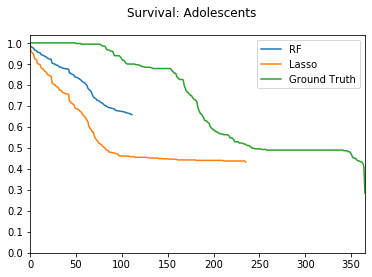

In [324]:
# display survival plot
plt.suptitle('Survival: Adolescents')
plt.plot(np.mean([person for person in pred_surv_rsf], axis=0), label='RF')
plt.plot(np.mean([person.y for person in pred_surv_rcr], axis=0), label='Lasso')
labels, temp = get_ground_truth(y_test)
plt.plot(labels, temp, label='Ground Truth')
plt.legend()
plt.xlim(0, 365)
plt.xticks(np.arange(0, 365, step=50))
plt.yticks(np.arange(0, 1.1, step=0.1))

fname = set_filename('survival_adol')
    
plt.savefig(fname)
plt.show()

Non-Adolescent Survival Analysis

In [325]:
non_adol_data = df[df.adol == 0]
non_adol_label = non_adol_data[[censoring_var, predictor_var]]
non_adol_data.drop(columns=[censoring_var, predictor_var], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(non_adol_data, non_adol_label, test_size=0.2)
y_train_censored = Surv.from_arrays(y_train[censoring_var].copy(), y_train[predictor_var].copy()) # structured array to ensure censoring of 365 value
y_test_censored = Surv.from_arrays(y_test[censoring_var].copy(), y_test[predictor_var].copy()) # structured array to ensure censoring of 365 value
print(X_train.shape, y_train_censored.shape)
print(X_test.shape, y_test_censored.shape)
print(non_adol_data.shape, non_adol_label.shape)

(788, 23) (788,)
(197, 23) (197,)
(985, 23) (985, 2)


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [326]:
%%time

gbsa = GradientBoostingSurvivalAnalysis()
gbsa.fit(X_train, y_train_censored)

CPU times: user 1.37 s, sys: 12.2 ms, total: 1.38 s
Wall time: 3 s


GradientBoostingSurvivalAnalysis(criterion='friedman_mse', dropout_rate=0.0,
                                 learning_rate=0.1, loss='coxph', max_depth=3,
                                 max_features=None, max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None, min_samples_leaf=1,
                                 min_samples_split=2,
                                 min_weight_fraction_leaf=0.0, n_estimators=100,
                                 presort='auto', random_state=None,
                                 subsample=1.0, verbose=0)

In [327]:
%%time

rsf = RandomSurvivalForest()
rsf.fit(X_train, y_train_censored)

CPU times: user 536 ms, sys: 40.5 ms, total: 576 ms
Wall time: 1.22 s


RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='auto',
                     max_leaf_nodes=None, min_samples_leaf=3,
                     min_samples_split=6, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=None, oob_score=False,
                     random_state=None, verbose=0, warm_start=False)

In [328]:
%%time

# l1_ratio = 1 adjusts model to implement LASSO method for penalties
# fit_baseline_model = True allows us to create survival/hazard plots after model is fit

rcr = CoxnetSurvivalAnalysis(fit_baseline_model=True, l1_ratio=1)
rcr.fit(X_train, y_train_censored)

CPU times: user 237 ms, sys: 6.52 ms, total: 243 ms
Wall time: 865 ms


CoxnetSurvivalAnalysis(alpha_min_ratio=0.0001, alphas=None, copy_X=True,
                       fit_baseline_model=True, l1_ratio=1, max_iter=100000,
                       n_alphas=100, normalize=False, penalty_factor=None,
                       tol=1e-07, verbose=False)

Non-Adolescent Statistics

In [329]:
# feature importances from Lasso
non_adol_feature_importance_lasso = pd.DataFrame({'Feature':X_train.columns, 
                                                  'Non_Adol':np.average(rcr.coef_, weights=rcr.alphas_, axis = 1),})
non_adol_feature_importance_lasso['Non_Adol_abs'] = np.absolute(non_adol_feature_importance_lasso['Non_Adol'])
non_adol_feature_importance_lasso = non_adol_feature_importance_lasso.nlargest(10,['Non_Adol']) # keep top 10 features
display_side_by_side(non_adol_feature_importance_lasso, 3)

,Feature,Non_Adol,Non_Adol_abs
15,primsev_cd_5,0.064412,0.064412
5,srprobg_cd,0.061079,0.061079
6,dssg_0_cd,0.058164,0.058164
,Feature,Non_Adol,Non_Adol_abs
21,%_public_assistanceg,0.041986,0.041986
20,%_unemployedg,0.026117,0.026117
13,r4ag_0_cd,0.024651,0.024651
,Feature,Non_Adol,Non_Adol_abs
12,SESg_0_cd,0.015201,0.015201
18,%_U18g,0.005018,0.005018


In [330]:
# feature importances from Boosted Random Forest
non_adol_feature_importance_rf = pd.DataFrame({'Feature':X_train.columns, 'Non_Adol':gbsa.feature_importances_,})
non_adol_feature_importance_rf = non_adol_feature_importance_rf.nlargest(10,['Non_Adol']) # keep top 10 features
display_side_by_side(non_adol_feature_importance_rf, 4)

,Feature,Non_Adol
14,primsev_cd_2,0.141184
22,%_povertyg,0.127328
,Feature,Non_Adol
3,gvsg_cd,0.071822
6,dssg_0_cd,0.067363
,Feature,Non_Adol
15,primsev_cd_5,0.054644
18,%_U18g,0.054277
,Feature,Non_Adol
20,%_unemployedg,0.045766


In [331]:
# concordance index
scores = {'Model': ['Random Forest Boosted', 'Random Forest', 'Lasso'], 
               'Non_Adol': [gbsa.score(X_test, y_test_censored), rsf.score(X_test, y_test_censored), 
                        rcr.score(X_test, y_test_censored)]}
non_adol_concordance = pd.DataFrame(data=scores)

Non-Adolescent Survival Curves

In [332]:
pred_surv_rsf = rsf.predict_survival_function(X_test)
pred_surv_rcr = rcr.predict_survival_function(X_test)

saving file to graphs/survival_non_adol_illicit_murder_hcd.png


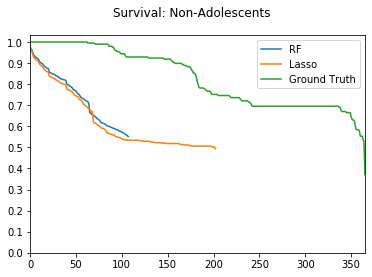

In [333]:
# display survival plot
plt.suptitle('Survival: Non-Adolescents')
plt.plot(np.mean([person for person in pred_surv_rsf], axis=0), label='RF')
plt.plot(np.mean([person.y for person in pred_surv_rcr], axis=0), label='Lasso')
labels, temp = get_ground_truth(y_test)
plt.plot(labels, temp, label='Ground Truth')
plt.legend()
plt.xlim(0, 365)
plt.xticks(np.arange(0, 365, step=50))
plt.yticks(np.arange(0, 1.1, step=0.1))

fname = set_filename('survival_non_adol')
    
plt.savefig(fname)
plt.show()

Overall Statistics

In [334]:
overall_concordance = pd.concat([adol_concordance, non_adol_concordance['Non_Adol'], 
                                 full_concordance['Full_Pop']], axis=1)
pd.DataFrame(data=overall_concordance)

,Model,Adol,Non_Adol,Full_Pop
0,Random Forest Boosted,0.751494,0.676631,0.684023
1,Random Forest,0.767883,0.697587,0.684188
2,Lasso,0.763568,0.659593,0.675283


In [335]:
overall_feature_importance_lasso = pd.merge(adol_feature_importance_lasso, non_adol_feature_importance_lasso,
                                            on='Feature', how='outer')
overall_feature_importance_lasso.fillna(0, inplace=True)
display_side_by_side(overall_feature_importance_lasso, 2)

,Feature,Adol,Adol_abs,Non_Adol,Non_Adol_abs
0,srprobg_cd,0.298360,0.298360,0.061079,0.061079
1,r4ag_0_cd,0.078064,0.078064,0.024651,0.024651
2,primsev_cd_2,-0.037022,0.037022,0.000000,0.000000
3,murder_numg,-0.017035,0.017035,0.000000,0.000000
4,gvsg_cd,0.015748,0.015748,0.000000,0.000000
5,adhdg_0_cd,0.011959,0.011959,0.001674,0.001674
6,cdsg_0_cd,0.011370,0.011370,0.000000,0.000000
7,primsev_cd_5,0.010219,0.010219,0.064412,0.064412
,Feature,Adol,Adol_abs,Non_Adol,Non_Adol_abs
8,epsg_0_cd,0.008651,0.008651,0.000000,0.000000


In [336]:
overall_feature_importance_rf = pd.merge(adol_feature_importance_rf, non_adol_feature_importance_rf, 
                                         on='Feature', how='outer')
overall_feature_importance_rf.fillna(0, inplace=True)
display_side_by_side(overall_feature_importance_rf, 4)

,Feature,Adol,Non_Adol
0,srprobg_cd,0.402958,0.044784
1,murder_numg,0.131584,0.000000
2,r4ag_0_cd,0.077330,0.037692
,Feature,Adol,Non_Adol
3,%_public_assistanceg,0.044563,0.042992
4,cdsg_0_cd,0.035155,0.000000
5,primsev_cd_2,0.034755,0.141184
,Feature,Adol,Non_Adol
6,primsev_cd_5,0.031363,0.054644
7,dssg_0_cd,0.029255,0.067363


saving file to graphs/feature_importances_lasso_age_illicit_murder_hcd.png


<Figure size 432x288 with 0 Axes>

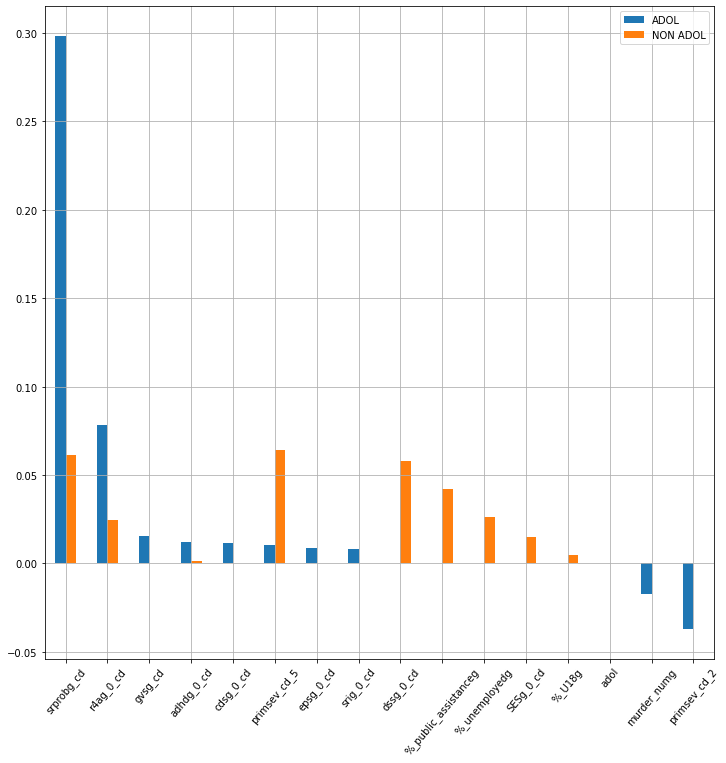

In [337]:
# feature importance for lasso across all ages
df = pd.DataFrame({'ADOL': overall_feature_importance_lasso['Adol'].tolist(),
                   'NON ADOL': overall_feature_importance_lasso['Non_Adol'].tolist()},
                  index=overall_feature_importance_lasso['Feature'].tolist())
df.sort_values(by=['ADOL'], ascending=False, inplace=True)
plt.suptitle('Feature Importance: Lasso')
ax = df.plot.bar(rot=50, figsize=(12, 12))
ax.grid()
fig = ax.get_figure()

fname = set_filename('feature_importances_lasso_age')
    
fig.savefig(fname, bbox_inches='tight')

saving file to graphs/feature_importances_rf_age_illicit_murder_hcd.png


<Figure size 432x288 with 0 Axes>

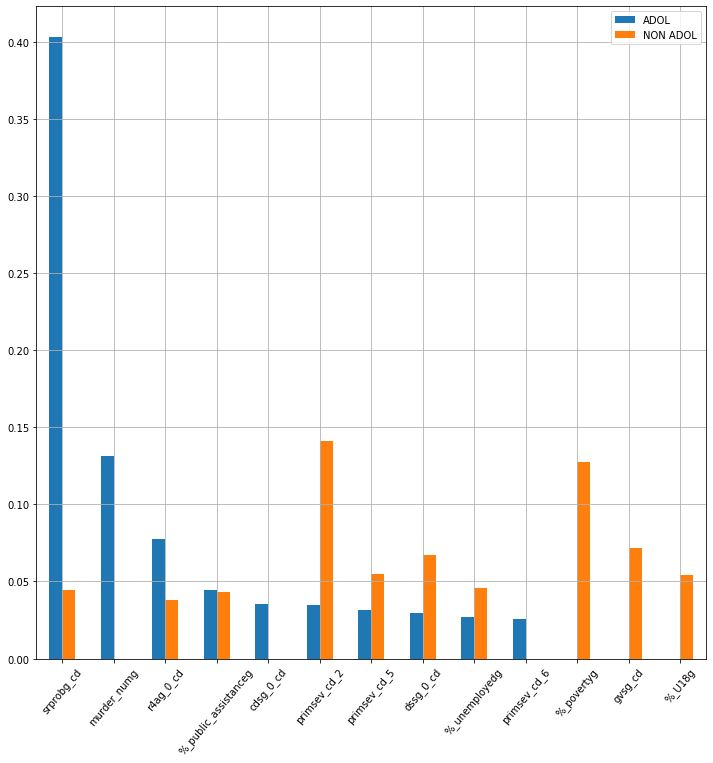

In [338]:
# feature importance for lasso across all ages
df = pd.DataFrame({'ADOL': overall_feature_importance_rf['Adol'].tolist(),
                   'NON ADOL': overall_feature_importance_rf['Non_Adol'].tolist()},
                  index=overall_feature_importance_rf['Feature'].tolist())
df.sort_values(by=['ADOL'], ascending=False, inplace=True)
plt.suptitle('Feature Importance: Lasso')
ax = df.plot.bar(rot=50, figsize=(12, 12))
ax.grid()
fig = ax.get_figure()

fname = set_filename('feature_importances_rf_age')
    
fig.savefig(fname, bbox_inches='tight')

In [339]:
# features in top 20-ish of both models across all ages
feature_importance_intersection = np.intersect1d(overall_feature_importance_rf['Feature'], 
                                                 overall_feature_importance_lasso['Feature'])
print('Common Features:', *list(feature_importance_intersection), sep =', ')

Common Features:, %_U18g, %_public_assistanceg, %_unemployedg, cdsg_0_cd, dssg_0_cd, gvsg_cd, murder_numg, primsev_cd_2, primsev_cd_5, r4ag_0_cd, srprobg_cd


In [340]:
# print out total notebook execution time
total_seconds = int(time.time() - start_time)
minutes = total_seconds // 60
seconds = total_seconds % 60
print("--- " + str(minutes) + " minutes " + str(seconds) + " seconds ---")

--- 0 minutes 52 seconds ---
